In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

In [2]:
# Função para ler o arquivo consolidado com os tipos corretos
def ler_dados_consolidados(arquivo="rodolfo/original_limpo.parquet"):
    """
    Lê o arquivo consolidado de microdados do IBGE.
    
    Parâmetros:
    -----------
    arquivo : str
        Caminho do arquivo Parquet a ser lido (padrão: "rodolfo/original_limpo.parquet")
    
    Retorna:
    --------
    DataFrame com as colunas nos tipos corretos (preservados automaticamente pelo Parquet):
    - Inteiros: Idade, NivelInstrucao, CursoGraduacaoCodigo, CursoMestradoCodigo, 
                CursoDoutoradoCodigo, OcupacaoCodigo, AtividadeCodigo, CBO-Domiciliar,
                CNAE-Domiciliar, QuantidadeSM, Genero
    - Float: ValorRenda, RendimentoAposentadoriaPensao
    - String: Estado
    
    Vantagens do Parquet:
    - Leitura 5-10x mais rápida que CSV
    - Tipos de dados preservados automaticamente
    - Compressão nativa (~50-70% menor que CSV)
    - Suporte a leitura parcial de colunas
    """
    df = pd.read_parquet(arquivo)
    return df

# Exemplo de uso:
# df = ler_dados_consolidados()
# print(df.info())
# print(df.head())

# Ler apenas colunas específicas (feature do Parquet):
# df_parcial = pd.read_parquet("rodolfo/original_limpo.parquet", columns=['Idade', 'ValorRenda', 'Estado'])

# Preparar a tabela para fazer o K-Means dos pares Curso x Ocupação

In [3]:
# Montar uma tabela cruzando os valores Curso vs Ocupação. Para isso, quero que as linhas indiquem todos os cursos e as colunas indiquem as ocupações. 
# Cada célula deve ter a porcentagem de pessoas naquele curso com aquela ocupação.
# Por exemplo, se 100 pessoas fizeram o curso de Engenharia e 30 delas trabalham como Engenheiro Civil, a célula correspondente deve ter o valor 30%.

def tabela_curso_ocupacao(df, curso_col='CursoGraduacaoCodigo', ocupacao_col='OcupacaoCodigo'):
    # Criar tabela cruzada
    tabela = pd.crosstab(df[curso_col], df[ocupacao_col], normalize='index') * 100
    
    # Renomear índices e colunas para melhor legibilidade (opcional)
    tabela.index.name = 'Curso de Graduação'
    tabela.columns.name = 'Código de Ocupação'
    
    return tabela
  
# Faça agora exatamente o oposto, as linhas tem a ocupação e as colunas os cursos.

def tabela_ocupacao_curso(df, curso_col='CursoGraduacaoCodigo', ocupacao_col='OcupacaoCodigo'):
    # Criar tabela cruzada
    tabela = pd.crosstab(df[ocupacao_col], df[curso_col], normalize='index') * 100
    
    # Renomear índices e colunas para melhor legibilidade (opcional)
    tabela.index.name = 'Código de Ocupação'
    tabela.columns.name = 'Curso de Graduação'
    
    return tabela
  

In [4]:
df = ler_dados_consolidados('rodolfo/original_filtrado.parquet')
tabela1 = tabela_curso_ocupacao(df)
tabela2 = tabela_ocupacao_curso(df)


# Técnicas de Redução de Esparsidade

Tabelas cruzadas de curso × ocupação tendem a ser muito esparsas. Aplicaremos técnicas para focar nas relações mais significativas.

In [5]:
def analisar_esparsidade(tabela, nome="Tabela"):
    """
    Analisa a esparsidade de uma tabela cruzada.
    """
    total_celulas = tabela.size
    celulas_nao_zero = (tabela > 0).sum().sum()
    celulas_significativas = (tabela > 1.0).sum().sum()  # > 1%
    
    print(f"\n{'='*60}")
    print(f"ANÁLISE DE ESPARSIDADE: {nome}")
    print(f"{'='*60}")
    print(f"Dimensões: {tabela.shape[0]} linhas × {tabela.shape[1]} colunas")
    print(f"Total de células: {total_celulas:,}")
    print(f"Células com valor > 0%: {celulas_nao_zero:,} ({celulas_nao_zero/total_celulas*100:.1f}%)")
    print(f"Células com valor > 1%: {celulas_significativas:,} ({celulas_significativas/total_celulas*100:.1f}%)")
    print(f"Esparsidade: {100 - (celulas_nao_zero/total_celulas*100):.1f}%")
    print(f"{'='*60}\n")

# Analisar esparsidade das tabelas originais
analisar_esparsidade(tabela1, "Curso → Ocupação")
analisar_esparsidade(tabela2, "Ocupação → Curso")


ANÁLISE DE ESPARSIDADE: Curso → Ocupação
Dimensões: 89 linhas × 433 colunas
Total de células: 38,537
Células com valor > 0%: 17,940 (46.6%)
Células com valor > 1%: 1,398 (3.6%)
Esparsidade: 53.4%


ANÁLISE DE ESPARSIDADE: Ocupação → Curso
Dimensões: 433 linhas × 89 colunas
Total de células: 38,537
Células com valor > 0%: 17,940 (46.6%)
Células com valor > 1%: 7,309 (19.0%)
Esparsidade: 53.4%



In [6]:
def filtrar_por_frequencia_minima(df, curso_col='CursoGraduacaoCodigo', ocupacao_col='OcupacaoCodigo', 
                                   min_pessoas_curso=100, min_pessoas_ocupacao=100):
    """
    Remove cursos e ocupações com poucos registros antes de criar a tabela cruzada.
    
    Parâmetros:
    -----------
    df : DataFrame
        DataFrame original
    min_pessoas_curso : int
        Número mínimo de pessoas por curso
    min_pessoas_ocupacao : int
        Número mínimo de pessoas por ocupação
    
    Retorna:
    --------
    DataFrame filtrado
    """
    # Contar frequências
    cursos_freq = df[curso_col].value_counts()
    ocupacoes_freq = df[ocupacao_col].value_counts()
    
    # Filtrar
    cursos_validos = cursos_freq[cursos_freq >= min_pessoas_curso].index
    ocupacoes_validas = ocupacoes_freq[ocupacoes_freq >= min_pessoas_ocupacao].index
    
    df_filtrado = df[df[curso_col].isin(cursos_validos) & df[ocupacao_col].isin(ocupacoes_validas)]
    
    print(f"📊 Filtro por frequência mínima:")
    print(f"   Cursos: {len(cursos_validos)} de {df[curso_col].nunique()} (mín: {min_pessoas_curso} pessoas)")
    print(f"   Ocupações: {len(ocupacoes_validas)} de {df[ocupacao_col].nunique()} (mín: {min_pessoas_ocupacao} pessoas)")
    print(f"   Registros mantidos: {len(df_filtrado):,} de {len(df):,} ({len(df_filtrado)/len(df)*100:.1f}%)\n")
    
    return df_filtrado

# Aplicar filtro
df_filtrado = filtrar_por_frequencia_minima(df, min_pessoas_curso=100, min_pessoas_ocupacao=100)

# Gerar tabelas filtradas
tabela1_filtrada = tabela_curso_ocupacao(df_filtrado)
tabela2_filtrada = tabela_ocupacao_curso(df_filtrado)

analisar_esparsidade(tabela1_filtrada, "Curso → Ocupação (Filtrada)")
analisar_esparsidade(tabela2_filtrada, "Ocupação → Curso (Filtrada)")

📊 Filtro por frequência mínima:
   Cursos: 79 de 89 (mín: 100 pessoas)
   Ocupações: 296 de 434 (mín: 100 pessoas)
   Registros mantidos: 873,910 de 1,126,884 (77.6%)


ANÁLISE DE ESPARSIDADE: Curso → Ocupação (Filtrada)
Dimensões: 79 linhas × 296 colunas
Total de células: 23,384
Células com valor > 0%: 15,529 (66.4%)
Células com valor > 1%: 1,263 (5.4%)
Esparsidade: 33.6%


ANÁLISE DE ESPARSIDADE: Ocupação → Curso (Filtrada)
Dimensões: 296 linhas × 79 colunas
Total de células: 23,384
Células com valor > 0%: 15,529 (66.4%)
Células com valor > 1%: 5,042 (21.6%)
Esparsidade: 33.6%


ANÁLISE DE ESPARSIDADE: Curso → Ocupação (Filtrada)
Dimensões: 79 linhas × 296 colunas
Total de células: 23,384
Células com valor > 0%: 15,529 (66.4%)
Células com valor > 1%: 1,263 (5.4%)
Esparsidade: 33.6%


ANÁLISE DE ESPARSIDADE: Ocupação → Curso (Filtrada)
Dimensões: 296 linhas × 79 colunas
Total de células: 23,384
Células com valor > 0%: 15,529 (66.4%)
Células com valor > 1%: 5,042 (21.6%)
Esparsidade: 3

In [7]:
def filtrar_por_threshold(tabela, threshold_pct=1.0):
    """
    Remove células com percentual muito baixo, mantendo apenas relações significativas.
    
    Parâmetros:
    -----------
    tabela : DataFrame
        Tabela cruzada com percentuais
    threshold_pct : float
        Percentual mínimo para manter a célula (default: 1.0%)
    
    Retorna:
    --------
    DataFrame com valores < threshold substituídos por 0
    """
    tabela_limpa = tabela.copy()
    tabela_limpa[tabela_limpa < threshold_pct] = 0
    
    # Remover linhas e colunas completamente vazias
    tabela_limpa = tabela_limpa.loc[(tabela_limpa > 0).any(axis=1), (tabela_limpa > 0).any(axis=0)]
    
    print(f"🔍 Filtro por threshold ({threshold_pct}%):")
    print(f"   Dimensões originais: {tabela.shape}")
    print(f"   Dimensões finais: {tabela_limpa.shape}")
    print(f"   Redução: {100 - (tabela_limpa.size/tabela.size*100):.1f}%\n")
    
    return tabela_limpa

# Aplicar threshold
tabela1_limpa = filtrar_por_threshold(tabela1_filtrada, threshold_pct=1.0)
tabela2_limpa = filtrar_por_threshold(tabela2_filtrada, threshold_pct=1.0)

analisar_esparsidade(tabela1_limpa, "Curso → Ocupação (Threshold 1%)")
analisar_esparsidade(tabela2_limpa, "Ocupação → Curso (Threshold 1%)")

🔍 Filtro por threshold (1.0%):
   Dimensões originais: (79, 296)
   Dimensões finais: (79, 194)
   Redução: 34.5%

🔍 Filtro por threshold (1.0%):
   Dimensões originais: (296, 79)
   Dimensões finais: (296, 73)
   Redução: 7.6%


ANÁLISE DE ESPARSIDADE: Curso → Ocupação (Threshold 1%)
Dimensões: 79 linhas × 194 colunas
Total de células: 15,326
Células com valor > 0%: 1,278 (8.3%)
Células com valor > 1%: 1,263 (8.2%)
Esparsidade: 91.7%


ANÁLISE DE ESPARSIDADE: Ocupação → Curso (Threshold 1%)
Dimensões: 296 linhas × 73 colunas
Total de células: 21,608
Células com valor > 0%: 5,058 (23.4%)
Células com valor > 1%: 5,042 (23.3%)
Esparsidade: 76.6%



In [8]:
def manter_top_n_relacoes(tabela, n=10):
    """
    Para cada linha, mantém apenas as N colunas com maiores percentuais.
    Útil para focar nas relações mais fortes.
    
    Parâmetros:
    -----------
    tabela : DataFrame
        Tabela cruzada com percentuais
    n : int
        Número de relações mais fortes a manter por linha
    
    Retorna:
    --------
    DataFrame esparso com apenas top-N relações por linha
    """
    tabela_top_n = tabela.copy()
    
    for idx in tabela_top_n.index:
        # Pegar os top N valores da linha
        top_n_cols = tabela_top_n.loc[idx].nlargest(n).index
        # Zerar todos os outros
        cols_to_zero = tabela_top_n.columns.difference(top_n_cols)
        tabela_top_n.loc[idx, cols_to_zero] = 0
    
    # Remover colunas completamente vazias
    tabela_top_n = tabela_top_n.loc[:, (tabela_top_n > 0).any(axis=0)]
    
    print(f"🎯 Top-{n} relações por linha:")
    print(f"   Dimensões originais: {tabela.shape}")
    print(f"   Dimensões finais: {tabela_top_n.shape}")
    print(f"   Células não-zero: {(tabela_top_n > 0).sum().sum():,}\n")
    
    return tabela_top_n

# Aplicar top-N
tabela1_top10 = manter_top_n_relacoes(tabela1_filtrada, n=10)
tabela2_top10 = manter_top_n_relacoes(tabela2_filtrada, n=10)

print("Para K-Means, recomendo usar as tabelas filtradas + top-N")
print("Isso garante foco nas relações mais significativas mantendo interpretabilidade.\n")

🎯 Top-10 relações por linha:
   Dimensões originais: (79, 296)
   Dimensões finais: (79, 163)
   Células não-zero: 790

🎯 Top-10 relações por linha:
   Dimensões originais: (296, 79)
   Dimensões finais: (296, 68)
   Células não-zero: 2,960

Para K-Means, recomendo usar as tabelas filtradas + top-N
Isso garante foco nas relações mais significativas mantendo interpretabilidade.

🎯 Top-10 relações por linha:
   Dimensões originais: (296, 79)
   Dimensões finais: (296, 68)
   Células não-zero: 2,960

Para K-Means, recomendo usar as tabelas filtradas + top-N
Isso garante foco nas relações mais significativas mantendo interpretabilidade.



In [9]:
def calcular_indice_concentracao(tabela):
    """
    Calcula o Índice de Herfindahl-Hirschman (HHI) para cada linha.
    HHI próximo de 10000 indica alta concentração (poucas ocupações dominantes).
    HHI próximo de 0 indica dispersão (muitas ocupações diferentes).
    
    Útil para identificar cursos muito específicos vs generalistas.
    """
    hhi = (tabela ** 2).sum(axis=1)
    
    resultado = pd.DataFrame({
        'HHI': hhi,
        'Interpretação': pd.cut(hhi, 
                                bins=[0, 1500, 2500, 10000],
                                labels=['Muito Disperso', 'Moderado', 'Concentrado'])
    }).sort_values('HHI', ascending=False)
    
    print("\n📈 Índice de Concentração (HHI) - Top 10 mais concentrados:")
    print(resultado.head(10))
    print("\n📉 Índice de Concentração (HHI) - Top 10 mais dispersos:")
    print(resultado.tail(10))
    
    return resultado

# Analisar concentração
print("="*60)
print("CURSOS → OCUPAÇÕES")
print("="*60)
hhi_cursos = calcular_indice_concentracao(tabela1_filtrada)

print("\n" + "="*60)
print("OCUPAÇÕES → CURSOS")
print("="*60)
hhi_ocupacoes = calcular_indice_concentracao(tabela2_filtrada)

CURSOS → OCUPAÇÕES

📈 Índice de Concentração (HHI) - Top 10 mais concentrados:
                            HHI Interpretação
Curso de Graduação                           
724                 7452.611899   Concentrado
721                 4209.931418   Concentrado
727                 3644.383571   Concentrado
641                 3195.680199   Concentrado
581                 3175.331628   Concentrado
723                 2735.999063   Concentrado
144                 2641.054117   Concentrado
762                 2532.425589   Concentrado
582                 2489.261831      Moderado
311                 2461.993688      Moderado

📉 Índice de Concentração (HHI) - Top 10 mais dispersos:
                           HHI   Interpretação
Curso de Graduação                            
540                 358.063876  Muito Disperso
812                 357.312868  Muito Disperso
340                 342.522573  Muito Disperso
814                 340.544055  Muito Disperso
811                 337.570256

## 💡 Recomendações para K-Means

**Abordagem sugerida:**

1. **Use `df_filtrado`** como base (remove cursos/ocupações raros)
2. **Aplique `threshold=1%`** para focar em relações significativas
3. **Ou use `top_n=10-15`** para cada curso/ocupação

**Justificativa:**
- Tabelas muito esparsas prejudicam clustering (curse of dimensionality)
- Valores < 1% são ruído estatístico
- Top-N garante interpretabilidade dos clusters

**Próximos passos:**
```python
# Para K-Means de cursos baseado em ocupações
X_cursos = tabela1_top10.fillna(0).values

# Para K-Means de ocupações baseado em cursos
X_ocupacoes = tabela2_top10.fillna(0).values
```

# Visualização: Matriz de Pares (Curso, Ocupação)

Cada ponto representa um par (curso, ocupação):
- **Eixo X:** % de alunos do curso que estão naquela ocupação
- **Eixo Y:** % da ocupação preenchida por alunos daquele curso

In [10]:
def criar_pontos_curso_ocupacao(tabela_curso_ocup, tabela_ocup_curso, min_threshold=1.0):
    """
    Cria pontos (x, y) onde:
    - x = % de alunos do curso que estão na ocupação
    - y = % da ocupação preenchida por alunos do curso
    
    Parâmetros:
    -----------
    tabela_curso_ocup : DataFrame
        Tabela curso → ocupação (linhas=cursos, colunas=ocupações)
    tabela_ocup_curso : DataFrame
        Tabela ocupação → curso (linhas=ocupações, colunas=cursos)
    min_threshold : float
        Percentual mínimo para incluir o ponto (default: 1.0%)
    
    Retorna:
    --------
    DataFrame com colunas: Curso, Ocupacao, X (%), Y (%), Tamanho
    """
    pontos = []
    
    # Iterar sobre todas as combinações curso-ocupação
    for curso in tabela_curso_ocup.index:
        for ocupacao in tabela_curso_ocup.columns:
            # X = % de alunos do curso nesta ocupação
            x = tabela_curso_ocup.loc[curso, ocupacao]
            
            # Y = % da ocupação preenchida por este curso
            # Precisa verificar se o curso existe nas colunas da tabela ocupacao->curso
            if curso in tabela_ocup_curso.columns and ocupacao in tabela_ocup_curso.index:
                y = tabela_ocup_curso.loc[ocupacao, curso]
            else:
                y = 0
            
            # Filtrar apenas pontos significativos
            if x >= min_threshold or y >= min_threshold:
                pontos.append({
                    'Curso': curso,
                    'Ocupacao': ocupacao,
                    'X_PctCurso': x,
                    'Y_PctOcupacao': y,
                    'Tamanho': np.sqrt(x * y)  # Tamanho proporcional à importância mútua
                })
    
    df_pontos = pd.DataFrame(pontos)
    
    print(f"📍 Pontos gerados: {len(df_pontos):,}")
    print(f"   Cursos únicos: {df_pontos['Curso'].nunique()}")
    print(f"   Ocupações únicas: {df_pontos['Ocupacao'].nunique()}")
    print(f"\n📊 Estatísticas:")
    print(f"   X (% do curso): média={df_pontos['X_PctCurso'].mean():.2f}%, max={df_pontos['X_PctCurso'].max():.2f}%")
    print(f"   Y (% da ocupação): média={df_pontos['Y_PctOcupacao'].mean():.2f}%, max={df_pontos['Y_PctOcupacao'].max():.2f}%")
    
    return df_pontos

# Gerar pontos usando as tabelas filtradas
df_pontos = criar_pontos_curso_ocupacao(tabela1_filtrada, tabela2_filtrada, min_threshold=1.0)

📍 Pontos gerados: 5,768
   Cursos únicos: 79
   Ocupações únicas: 296

📊 Estatísticas:
   X (% do curso): média=1.07%, max=86.29%
   Y (% da ocupação): média=4.54%, max=93.60%


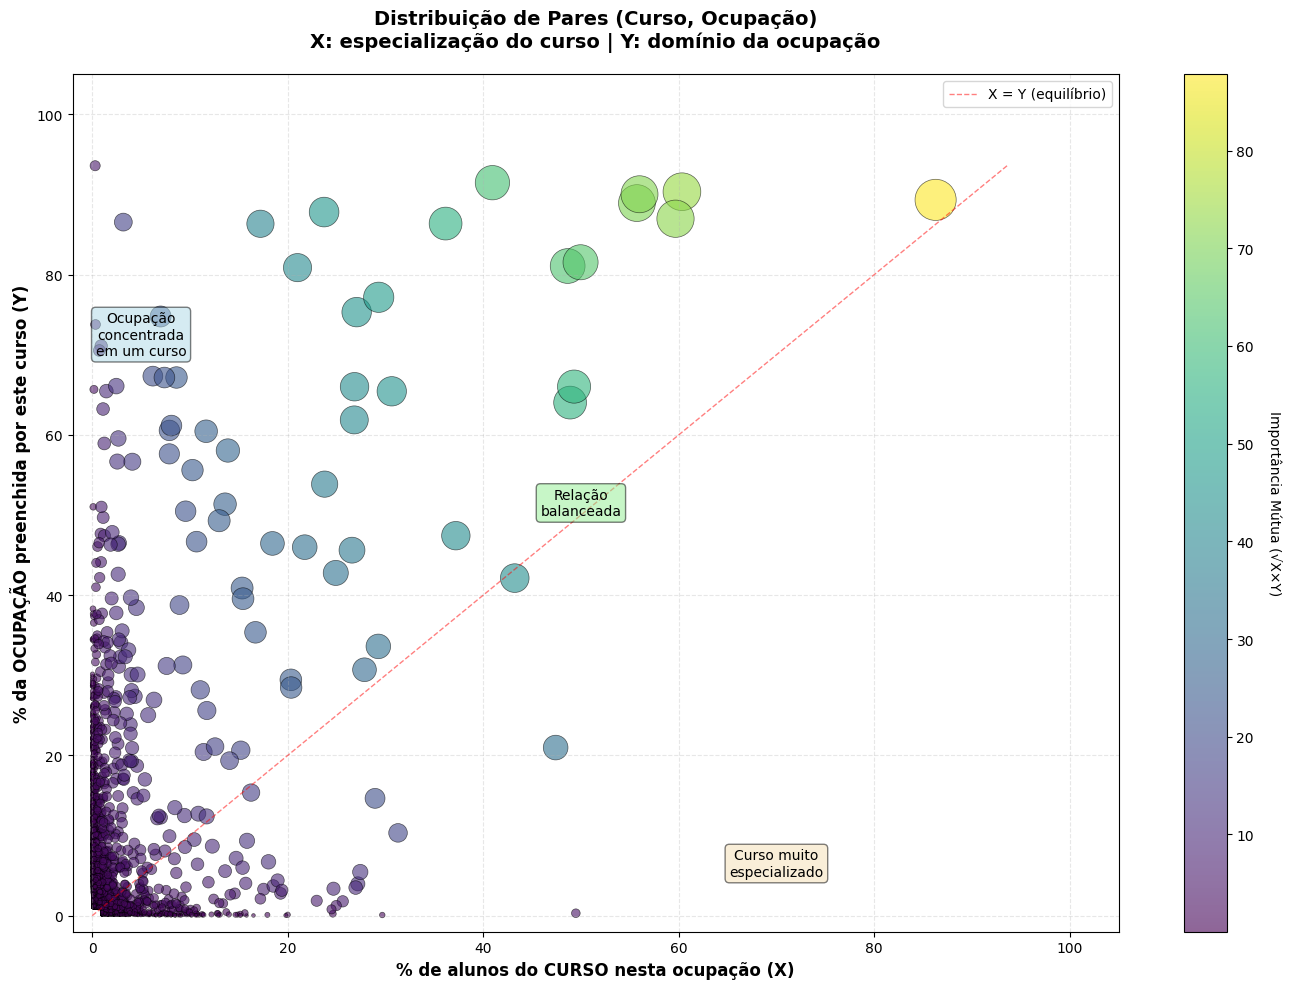


INTERPRETAÇÃO DA VISUALIZAÇÃO

🔵 Pontos no CANTO INFERIOR DIREITO (X alto, Y baixo):
   → Curso muito especializado, mas ocupa pequena parte da ocupação
   → Ex: Curso específico que leva 70% dos alunos para uma ocupação
        mas representa apenas 5% dos profissionais naquela ocupação

🔵 Pontos no CANTO SUPERIOR ESQUERDO (X baixo, Y alto):
   → Ocupação muito concentrada neste curso
   → Ex: 70% da ocupação vem deste curso,
        mas apenas 5% dos alunos do curso vão para lá

🔵 Pontos na DIAGONAL (X ≈ Y):
   → Relação balanceada e forte
   → Ex: 30% dos alunos vão para a ocupação
        E 30% da ocupação vem deste curso

🔵 Pontos no CANTO SUPERIOR DIREITO (X e Y altos):
   → RELAÇÃO MUITO FORTE: curso dominante para a ocupação
   → Ex: Medicina → Médico, Direito → Advogado


In [11]:
# Visualização: Scatter plot dos pares (curso, ocupação)
plt.figure(figsize=(14, 10))

# Scatter plot com tamanho proporcional à importância
scatter = plt.scatter(
    df_pontos['X_PctCurso'], 
    df_pontos['Y_PctOcupacao'],
    s=df_pontos['Tamanho'] * 10,  # Tamanho do ponto
    alpha=0.6,
    c=df_pontos['Tamanho'],  # Cor baseada na importância
    cmap='viridis',
    edgecolors='black',
    linewidth=0.5
)

plt.xlabel('% de alunos do CURSO nesta ocupação (X)', fontsize=12, fontweight='bold')
plt.ylabel('% da OCUPAÇÃO preenchida por este curso (Y)', fontsize=12, fontweight='bold')
plt.title('Distribuição de Pares (Curso, Ocupação)\nX: especialização do curso | Y: domínio da ocupação', 
          fontsize=14, fontweight='bold', pad=20)

# Grid para facilitar leitura
plt.grid(True, alpha=0.3, linestyle='--')

# Colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Importância Mútua (√X×Y)', rotation=270, labelpad=20)

# Linha de referência diagonal (onde X = Y)
max_val = max(df_pontos['X_PctCurso'].max(), df_pontos['Y_PctOcupacao'].max())
plt.plot([0, max_val], [0, max_val], 'r--', alpha=0.5, linewidth=1, label='X = Y (equilíbrio)')

# Anotações de regiões
plt.text(70, 5, 'Curso muito\nespecializado', fontsize=10, ha='center', 
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.text(5, 70, 'Ocupação\nconcentrada\nem um curso', fontsize=10, ha='center',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
plt.text(50, 50, 'Relação\nbalanceada', fontsize=10, ha='center',
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

plt.xlim(-2, 105)
plt.ylim(-2, 105)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# Estatísticas sobre a distribuição
print("\n" + "="*60)
print("INTERPRETAÇÃO DA VISUALIZAÇÃO")
print("="*60)
print("\n🔵 Pontos no CANTO INFERIOR DIREITO (X alto, Y baixo):")
print("   → Curso muito especializado, mas ocupa pequena parte da ocupação")
print("   → Ex: Curso específico que leva 70% dos alunos para uma ocupação")
print("        mas representa apenas 5% dos profissionais naquela ocupação")

print("\n🔵 Pontos no CANTO SUPERIOR ESQUERDO (X baixo, Y alto):")
print("   → Ocupação muito concentrada neste curso")
print("   → Ex: 70% da ocupação vem deste curso,")
print("        mas apenas 5% dos alunos do curso vão para lá")

print("\n🔵 Pontos na DIAGONAL (X ≈ Y):")
print("   → Relação balanceada e forte")
print("   → Ex: 30% dos alunos vão para a ocupação")
print("        E 30% da ocupação vem deste curso")

print("\n🔵 Pontos no CANTO SUPERIOR DIREITO (X e Y altos):")
print("   → RELAÇÃO MUITO FORTE: curso dominante para a ocupação")
print("   → Ex: Medicina → Médico, Direito → Advogado")
print("="*60)

In [12]:
# Identificar os pontos mais relevantes em cada região

print("\n" + "="*60)
print("TOP 10 RELAÇÕES MAIS FORTES (X e Y altos)")
print("="*60)
df_fortes = df_pontos.nlargest(10, 'Tamanho')[['Curso', 'Ocupacao', 'X_PctCurso', 'Y_PctOcupacao', 'Tamanho']]
print(df_fortes.to_string(index=False))

print("\n" + "="*60)
print("TOP 10 CURSOS MAIS ESPECIALIZADOS (X alto, Y baixo)")
print("="*60)
df_especializados = df_pontos[df_pontos['Y_PctOcupacao'] < 10].nlargest(10, 'X_PctCurso')[['Curso', 'Ocupacao', 'X_PctCurso', 'Y_PctOcupacao']]
print(df_especializados.to_string(index=False))

print("\n" + "="*60)
print("TOP 10 OCUPAÇÕES CONCENTRADAS (Y alto, X baixo)")
print("="*60)
df_concentradas = df_pontos[df_pontos['X_PctCurso'] < 10].nlargest(10, 'Y_PctOcupacao')[['Curso', 'Ocupacao', 'X_PctCurso', 'Y_PctOcupacao']]
print(df_concentradas.to_string(index=False))

print("\n" + "="*60)
print("TOP 10 RELAÇÕES MAIS BALANCEADAS (X ≈ Y)")
print("="*60)
df_pontos['Diferenca'] = abs(df_pontos['X_PctCurso'] - df_pontos['Y_PctOcupacao'])
df_balanceadas = df_pontos[df_pontos['Tamanho'] > 5].nsmallest(10, 'Diferenca')[['Curso', 'Ocupacao', 'X_PctCurso', 'Y_PctOcupacao', 'Diferenca']]
print(df_balanceadas.to_string(index=False))
print("="*60)


TOP 10 RELAÇÕES MAIS FORTES (X e Y altos)
 Curso  Ocupacao  X_PctCurso  Y_PctOcupacao   Tamanho
   724      2261   86.287558      89.338159 87.799610
   721      2211   60.333422      90.354284 73.833482
   727      2262   59.676357      86.985738 72.048539
   641      2250   55.993001      90.039392 71.004055
   581      2161   55.729962      88.938151 70.402556
   723      2221   49.963977      81.552256 63.833181
   311      2634   48.643815      81.083095 62.802795
   380      2611   40.947256      91.482998 61.204393
   762      2635   49.297988      66.035088 57.056086
   582      2142   48.895409      64.037071 55.956401

TOP 10 CURSOS MAIS ESPECIALIZADOS (X alto, Y baixo)
 Curso  Ocupacao  X_PctCurso  Y_PctOcupacao
   144      2341   49.479941       0.310238
   140      2341   29.677419       0.085711
   623      2132   27.426810       5.453431
   346      4120   27.176995       3.974883
   461      2341   26.956086       3.511371
   222      2341   25.632490       1.793417
  

# Visualização Interativa com Filtros Ajustáveis

Use os sliders abaixo para ajustar os filtros e explorar as relações mais significativas.

In [ ]:
from ipywidgets import interact, FloatSlider, IntSlider, Button, VBox, HBox, Output
import ipywidgets as widgets

def plotar_grafico_interativo(min_x_pct=1.0, min_y_pct=1.0, tamanho_min=0.0):
    """
    Plota o gráfico de dispersão com filtros ajustáveis.
    
    Parâmetros:
    -----------
    min_x_pct : float
        Percentual mínimo de X (% do curso na ocupação)
    min_y_pct : float
        Percentual mínimo de Y (% da ocupação do curso)
    tamanho_min : float
        Tamanho mínimo (importância mútua)
    """
    # Filtrar pontos baseado nos critérios
    df_filtrado = df_pontos[
        (df_pontos['X_PctCurso'] >= min_x_pct) & 
        (df_pontos['Y_PctOcupacao'] >= min_y_pct) &
        (df_pontos['Tamanho'] >= tamanho_min)
    ].copy()
    
    if len(df_filtrado) == 0:
        print("⚠️ Nenhum ponto atende aos critérios. Relaxe os filtros.")
        return
    
    # Criar figura
    plt.figure(figsize=(14, 10))
    
    # Scatter plot
    scatter = plt.scatter(
        df_filtrado['X_PctCurso'], 
        df_filtrado['Y_PctOcupacao'],
        s=df_filtrado['Tamanho'] * 10,
        alpha=0.6,
        c=df_filtrado['Tamanho'],
        cmap='viridis',
        edgecolors='black',
        linewidth=0.5
    )
    
    plt.xlabel('% de alunos do CURSO nesta ocupação (X)', fontsize=12, fontweight='bold')
    plt.ylabel('% da OCUPAÇÃO preenchida por este curso (Y)', fontsize=12, fontweight='bold')
    plt.title(f'Pares (Curso, Ocupação) Filtrados\nX ≥ {min_x_pct}% | Y ≥ {min_y_pct}% | Importância ≥ {tamanho_min:.1f}', 
              fontsize=14, fontweight='bold', pad=20)
    
    # Grid
    plt.grid(True, alpha=0.3, linestyle='--')
    
    # Colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Importância Mútua (√X×Y)', rotation=270, labelpad=20)
    
    # Linha diagonal
    max_val = max(df_filtrado['X_PctCurso'].max(), df_filtrado['Y_PctOcupacao'].max())
    plt.plot([0, max_val], [0, max_val], 'r--', alpha=0.5, linewidth=1, label='X = Y')
    
    # Anotações
    plt.text(70, 5, 'Curso\nespecializado', fontsize=9, ha='center', 
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    plt.text(5, 70, 'Ocupação\nconcentrada', fontsize=9, ha='center',
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
    plt.text(50, 50, 'Relação\nbalanceada', fontsize=9, ha='center',
             bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))
    
    plt.xlim(-2, 105)
    plt.ylim(-2, 105)
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()
    
    # Estatísticas
    print(f"\n📊 Estatísticas dos pontos filtrados:")
    print(f"   Total de pontos: {len(df_filtrado):,} (de {len(df_pontos):,})")
    print(f"   Cursos únicos: {df_filtrado['Curso'].nunique()}")
    print(f"   Ocupações únicas: {df_filtrado['Ocupacao'].nunique()}")
    print(f"   X médio: {df_filtrado['X_PctCurso'].mean():.2f}%")
    print(f"   Y médio: {df_filtrado['Y_PctOcupacao'].mean():.2f}%")
    print(f"   Importância média: {df_filtrado['Tamanho'].mean():.2f}")

# Criar widgets interativos
interact(
    plotar_grafico_interativo,
    min_x_pct=FloatSlider(
        value=1.0,
        min=0.0,
        max=20.0,
        step=0.5,
        description='Min X (%):',
        continuous_update=False,
        style={'description_width': '120px'}
    ),
    min_y_pct=FloatSlider(
        value=1.0,
        min=0.0,
        max=20.0,
        step=0.5,
        description='Min Y (%):',
        continuous_update=False,
        style={'description_width': '120px'}
    ),
    tamanho_min=FloatSlider(
        value=0.0,
        min=0.0,
        max=15.0,
        step=0.5,
        description='Min Importância:',
        continuous_update=False,
        style={'description_width': '120px'}
    )
);

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='Min X (%):', max=20.0, step…

In [14]:
import plotly.graph_objects as go
import plotly.express as px

def plotar_grafico_interativo_plotly(min_x_pct=1.0, min_y_pct=1.0, tamanho_min=0.0):
    """
    Plota o gráfico de dispersão interativo com Plotly (mostra curso/ocupação ao passar o mouse).
    
    Parâmetros:
    -----------
    min_x_pct : float
        Percentual mínimo de X (% do curso na ocupação)
    min_y_pct : float
        Percentual mínimo de Y (% da ocupação do curso)
    tamanho_min : float
        Tamanho mínimo (importância mútua)
    """
    # Filtrar pontos baseado nos critérios
    df_filtrado = df_pontos[
        (df_pontos['X_PctCurso'] >= min_x_pct) & 
        (df_pontos['Y_PctOcupacao'] >= min_y_pct) &
        (df_pontos['Tamanho'] >= tamanho_min)
    ].copy()
    
    if len(df_filtrado) == 0:
        print("⚠️ Nenhum ponto atende aos critérios. Relaxe os filtros.")
        return
    
    # Criar texto customizado para hover
    df_filtrado['hover_text'] = df_filtrado.apply(
        lambda row: f"<b>Curso:</b> {row['Curso']}<br>" +
                    f"<b>Ocupação:</b> {row['Ocupacao']}<br>" +
                    f"<b>X (% do curso):</b> {row['X_PctCurso']:.1f}%<br>" +
                    f"<b>Y (% da ocupação):</b> {row['Y_PctOcupacao']:.1f}%<br>" +
                    f"<b>Importância:</b> {row['Tamanho']:.1f}",
        axis=1
    )
    
    # Criar figura Plotly
    fig = go.Figure()
    
    # Adicionar scatter plot
    fig.add_trace(go.Scatter(
        x=df_filtrado['X_PctCurso'],
        y=df_filtrado['Y_PctOcupacao'],
        mode='markers',
        marker=dict(
            size=df_filtrado['Tamanho'] * 0.5,  # Tamanho do ponto (reduzido)
            color=df_filtrado['Tamanho'],  # Cor baseada na importância
            colorscale='Viridis',
            showscale=True,
            colorbar=dict(title="Importância<br>Mútua"),
            line=dict(width=0.5, color='black'),
            opacity=0.7
        ),
        text=df_filtrado['hover_text'],
        hovertemplate='%{text}<extra></extra>',
        name=''
    ))
    
    # Adicionar linha diagonal
    max_val = max(df_filtrado['X_PctCurso'].max(), df_filtrado['Y_PctOcupacao'].max())
    fig.add_trace(go.Scatter(
        x=[0, max_val],
        y=[0, max_val],
        mode='lines',
        line=dict(color='red', width=1, dash='dash'),
        name='X = Y',
        hoverinfo='skip'
    ))
    
    # Adicionar anotações de regiões
    annotations = [
        dict(x=70, y=5, text="Curso<br>especializado", 
             showarrow=False, bgcolor="wheat", opacity=0.7, font=dict(size=10)),
        dict(x=5, y=70, text="Ocupação<br>concentrada", 
             showarrow=False, bgcolor="lightblue", opacity=0.7, font=dict(size=10)),
        dict(x=50, y=50, text="Relação<br>balanceada", 
             showarrow=False, bgcolor="lightgreen", opacity=0.7, font=dict(size=10))
    ]
    
    # Layout
    fig.update_layout(
        title=dict(
            text=f'Pares (Curso, Ocupação) Filtrados<br>' +
                 f'<sub>X ≥ {min_x_pct}% | Y ≥ {min_y_pct}% | Importância ≥ {tamanho_min:.1f}</sub>',
            x=0.5,
            xanchor='center'
        ),
        xaxis=dict(
            title='<b>% de alunos do CURSO nesta ocupação (X)</b>',
            range=[-2, 105],
            gridcolor='lightgray',
            gridwidth=0.5
        ),
        yaxis=dict(
            title='<b>% da OCUPAÇÃO preenchida por este curso (Y)</b>',
            range=[-2, 105],
            gridcolor='lightgray',
            gridwidth=0.5
        ),
        annotations=annotations,
        hovermode='closest',
        width=1000,
        height=800,
        showlegend=True,
        plot_bgcolor='white'
    )
    
    fig.show()
    
    # Estatísticas
    print(f"\n📊 Estatísticas dos pontos filtrados:")
    print(f"   Total de pontos: {len(df_filtrado):,} (de {len(df_pontos):,})")
    print(f"   Cursos únicos: {df_filtrado['Curso'].nunique()}")
    print(f"   Ocupações únicas: {df_filtrado['Ocupacao'].nunique()}")
    print(f"   X médio: {df_filtrado['X_PctCurso'].mean():.2f}%")
    print(f"   Y médio: {df_filtrado['Y_PctOcupacao'].mean():.2f}%")
    print(f"   Importância média: {df_filtrado['Tamanho'].mean():.2f}")

# Criar widgets interativos com Plotly
interact(
    plotar_grafico_interativo_plotly,
    min_x_pct=FloatSlider(
        value=1.0,
        min=0.0,
        max=20.0,
        step=0.5,
        description='Min X (%):',
        continuous_update=False,
        style={'description_width': '120px'}
    ),
    min_y_pct=FloatSlider(
        value=1.0,
        min=0.0,
        max=20.0,
        step=0.5,
        description='Min Y (%):',
        continuous_update=False,
        style={'description_width': '120px'}
    ),
    tamanho_min=FloatSlider(
        value=0.0,
        min=0.0,
        max=15.0,
        step=0.5,
        description='Min Importância:',
        continuous_update=False,
        style={'description_width': '120px'}
    )
);

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='Min X (%):', max=20.0, step…

# K-Means Clustering dos Pares (Curso, Ocupação)

Vamos agrupar os pares mais significativos usando K-Means para identificar padrões de relações.

In [15]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Filtrar pontos com os critérios especificados
min_x_pct = 10.0
min_y_pct = 10.0
tamanho_min = 10.0

df_kmeans = df_pontos[
    (df_pontos['X_PctCurso'] >= min_x_pct) & 
    (df_pontos['Y_PctOcupacao'] >= min_y_pct) &
    (df_pontos['Tamanho'] >= tamanho_min)
].copy()

print(f"📊 Dados para K-Means:")
print(f"   Total de pontos: {len(df_kmeans):,}")
print(f"   Cursos únicos: {df_kmeans['Curso'].nunique()}")
print(f"   Ocupações únicas: {df_kmeans['Ocupacao'].nunique()}")

# Preparar dados para clustering (usar X e Y)
X_cluster = df_kmeans[['X_PctCurso', 'Y_PctOcupacao']].values

# Normalizar os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

print(f"\n✅ Dados normalizados: {X_scaled.shape}")

📊 Dados para K-Means:
   Total de pontos: 51
   Cursos únicos: 42
   Ocupações únicas: 44

✅ Dados normalizados: (51, 2)


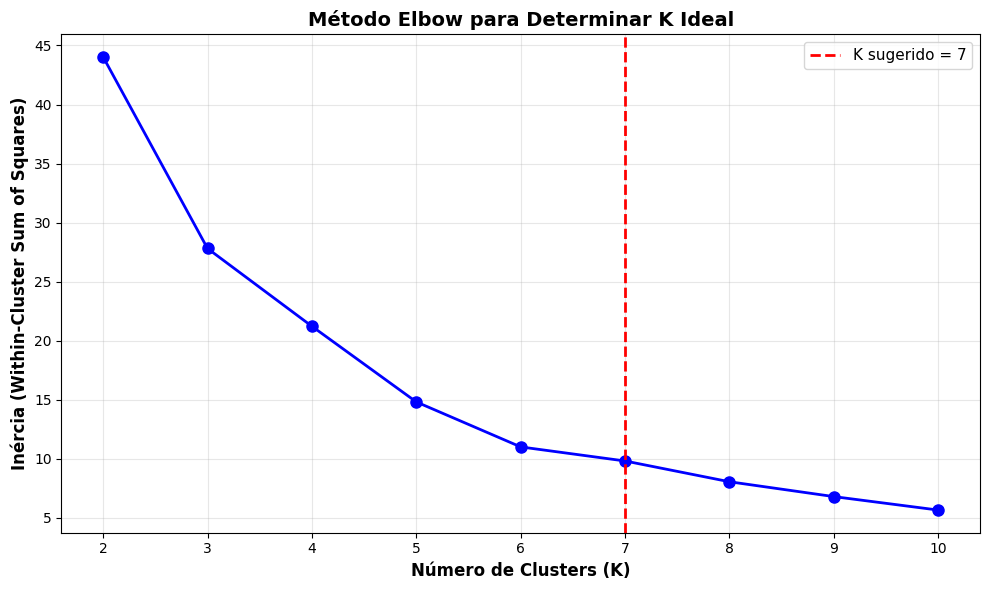


🎯 Método Elbow sugere K = 7 clusters

📉 Inércias por K:
   K=2: 44.03
   K=3: 27.81
   K=4: 21.22
   K=5: 14.82
   K=6: 11.01
   K=7: 9.82 ← SUGERIDO
   K=8: 8.06
   K=9: 6.80
   K=10: 5.66


In [16]:
# Método Elbow para determinar o número ideal de clusters
inertias = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# Plotar o gráfico Elbow
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Número de Clusters (K)', fontsize=12, fontweight='bold')
plt.ylabel('Inércia (Within-Cluster Sum of Squares)', fontsize=12, fontweight='bold')
plt.title('Método Elbow para Determinar K Ideal', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(K_range)

# Marcar o ponto de inflexão (regra simples: maior mudança de inclinação)
# Calcular as diferenças de segunda ordem
diffs = np.diff(inertias, 2)
elbow_k = K_range[np.argmin(diffs) + 1]
plt.axvline(x=elbow_k, color='red', linestyle='--', linewidth=2, label=f'K sugerido = {elbow_k}')

plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

print(f"\n🎯 Método Elbow sugere K = {elbow_k} clusters")
print(f"\n📉 Inércias por K:")
for k, inertia in zip(K_range, inertias):
    marker = " ← SUGERIDO" if k == elbow_k else ""
    print(f"   K={k}: {inertia:.2f}{marker}")

In [17]:
elbow_k = 3

In [18]:
# Aplicar K-Means com o K ideal
kmeans_final = KMeans(n_clusters=elbow_k, random_state=42, n_init=10)
df_kmeans['Cluster'] = kmeans_final.fit_predict(X_scaled)

# Estatísticas dos clusters
print(f"\n" + "="*60)
print(f"ANÁLISE DOS CLUSTERS (K={elbow_k})")
print("="*60)

for cluster_id in range(elbow_k):
    cluster_data = df_kmeans[df_kmeans['Cluster'] == cluster_id]
    print(f"\n🔹 Cluster {cluster_id}:")
    print(f"   Pontos: {len(cluster_data):,}")
    print(f"   X médio: {cluster_data['X_PctCurso'].mean():.1f}%")
    print(f"   Y médio: {cluster_data['Y_PctOcupacao'].mean():.1f}%")
    print(f"   Importância média: {cluster_data['Tamanho'].mean():.1f}")
    print(f"   Cursos únicos: {cluster_data['Curso'].nunique()}")
    print(f"   Ocupações únicas: {cluster_data['Ocupacao'].nunique()}")

print("\n" + "="*60)


ANÁLISE DOS CLUSTERS (K=3)

🔹 Cluster 0:
   Pontos: 11
   X médio: 53.8%
   Y médio: 83.3%
   Importância média: 66.5
   Cursos únicos: 11
   Ocupações únicas: 11

🔹 Cluster 1:
   Pontos: 19
   X médio: 19.4%
   Y médio: 24.2%
   Importância média: 20.7
   Cursos únicos: 16
   Ocupações únicas: 15

🔹 Cluster 2:
   Pontos: 21
   X médio: 22.5%
   Y médio: 59.4%
   Importância média: 35.6
   Cursos únicos: 20
   Ocupações únicas: 21



In [19]:
# Gráfico interativo Plotly com clusters coloridos - CORRIGIDO
import plotly.graph_objects as go
import plotly.express as px

# Criar figura vazia
fig = go.Figure()

# Cores para cada cluster
cores = px.colors.qualitative.Set2

# Plotar cada cluster separadamente usando go.Scatter
for cluster_id in sorted(df_kmeans['Cluster'].unique()):
    cluster_data = df_kmeans[df_kmeans['Cluster'] == cluster_id].copy()
    
    # Criar texto de hover para este cluster
    hover_texts = []
    for idx, row in cluster_data.iterrows():
        hover_texts.append(
            f"<b>Curso:</b> {int(row['Curso'])}<br>" +
            f"<b>Ocupação:</b> {int(row['Ocupacao'])}<br>" +
            f"<b>X (% do curso):</b> {row['X_PctCurso']:.1f}%<br>" +
            f"<b>Y (% da ocupação):</b> {row['Y_PctOcupacao']:.1f}%<br>" +
            f"<b>Importância:</b> {row['Tamanho']:.1f}<br>" +
            f"<b>Cluster:</b> {int(row['Cluster'])}"
        )
    
    # Adicionar trace para este cluster
    fig.add_trace(go.Scatter(
        x=cluster_data['X_PctCurso'].values,
        y=cluster_data['Y_PctOcupacao'].values,
        mode='markers',
        name=f'Cluster {cluster_id}',
        marker=dict(
            size=cluster_data['Tamanho'].values * 0.5,
            color=cores[cluster_id % len(cores)],
            line=dict(width=0.5, color='black'),
            opacity=0.8
        ),
        text=hover_texts,
        hovertemplate='%{text}<extra></extra>'
    ))

# Adicionar linha diagonal
max_val = max(df_kmeans['X_PctCurso'].max(), df_kmeans['Y_PctOcupacao'].max())
fig.add_trace(go.Scatter(
    x=[0, max_val],
    y=[0, max_val],
    mode='lines',
    line=dict(color='red', width=1, dash='dash'),
    name='X = Y',
    hoverinfo='skip',
    showlegend=True
))

# Layout com título e anotações
fig.update_layout(
    title=f'K-Means Clustering: Pares (Curso, Ocupação) - CORRIGIDO<br><sub>K={elbow_k} clusters | X≥{min_x_pct}% | Y≥{min_y_pct}% | Importância≥{tamanho_min}</sub>',
    xaxis=dict(
        title='<b>% de alunos do CURSO nesta ocupação (X)</b>',
        range=[-2, 105],
        gridcolor='lightgray',
        gridwidth=0.5
    ),
    yaxis=dict(
        title='<b>% da OCUPAÇÃO preenchida por este curso (Y)</b>',
        range=[-2, 105],
        gridcolor='lightgray',
        gridwidth=0.5
    ),
    hovermode='closest',
    width=1100,
    height=800,
    plot_bgcolor='white',
    legend=dict(
        title=dict(text='<b>Clusters</b>'),
        orientation='v',
        yanchor='top',
        y=0.99,
        xanchor='right',
        x=0.99
    ),
    annotations=[
        dict(x=70, y=5, text="Curso<br>especializado", 
             showarrow=False, bgcolor="wheat", opacity=0.6, font=dict(size=10)),
        dict(x=5, y=70, text="Ocupação<br>concentrada", 
             showarrow=False, bgcolor="lightblue", opacity=0.6, font=dict(size=10)),
        dict(x=50, y=50, text="Relação<br>balanceada", 
             showarrow=False, bgcolor="lightgreen", opacity=0.6, font=dict(size=10))
    ]
)

fig.show()

print(f"\n✨ Visualização CORRIGIDA com {elbow_k} clusters gerada!")
print("   Passe o mouse sobre os pontos para ver detalhes")
print("   Clique nas legendas para mostrar/ocultar clusters")
print("   ⚠️  BUG CORRIGIDO: Agora as posições visuais correspondem aos valores do tooltip")


✨ Visualização CORRIGIDA com 3 clusters gerada!
   Passe o mouse sobre os pontos para ver detalhes
   Clique nas legendas para mostrar/ocultar clusters
   ⚠️  BUG CORRIGIDO: Agora as posições visuais correspondem aos valores do tooltip


## Análise Detalhada: Curso 213

Vamos examinar as ocupações associadas ao curso 213 na tabela original.

In [20]:
# Analisar curso 213 na tabela original
curso_codigo = 213

print(f"{'='*70}")
print(f"ANÁLISE DO CURSO {curso_codigo}")
print(f"{'='*70}")

# Verificar se o curso existe na tabela
if curso_codigo in tabela1_filtrada.index:
    # Pegar todas as ocupações deste curso (não-zero)
    ocupacoes_curso = tabela1_filtrada.loc[curso_codigo]
    ocupacoes_curso = ocupacoes_curso[ocupacoes_curso > 0].sort_values(ascending=False)
    
    print(f"\n📊 Total de alunos do curso 213 no dataset:")
    total_curso = df_filtrado[df_filtrado['CursoGraduacaoCodigo'] == curso_codigo].shape[0]
    print(f"   {total_curso:,} pessoas")
    
    print(f"\n📋 Distribuição por ocupações ({len(ocupacoes_curso)} ocupações diferentes):")
    print(f"{'─'*70}")
    print(f"{'Código Ocupação':<18} {'% do Curso':<15} {'Qtd Estimada':<15}")
    print(f"{'─'*70}")
    
    for ocupacao, pct in ocupacoes_curso.head(20).items():
        qtd_estimada = int(total_curso * pct / 100)
        print(f"{ocupacao:<18} {pct:>6.2f}%{'':<9} ~{qtd_estimada:>5} pessoas")
    
    if len(ocupacoes_curso) > 20:
        print(f"{'─'*70}")
        print(f"... e mais {len(ocupacoes_curso) - 20} ocupações com percentuais menores")
    
    print(f"{'─'*70}")
    print(f"{'TOTAL':<18} {ocupacoes_curso.sum():>6.2f}%{'':<9} ~{total_curso:>5} pessoas")
    print(f"{'='*70}")
    
    # Estatísticas adicionais
    print(f"\n📈 Estatísticas de concentração:")
    print(f"   Top 3 ocupações: {ocupacoes_curso.head(3).sum():.1f}%")
    print(f"   Top 5 ocupações: {ocupacoes_curso.head(5).sum():.1f}%")
    print(f"   Top 10 ocupações: {ocupacoes_curso.head(10).sum():.1f}%")
    
    # Calcular HHI para este curso
    hhi_curso = (ocupacoes_curso ** 2).sum()
    print(f"\n📊 Índice de Concentração (HHI): {hhi_curso:.1f}")
    if hhi_curso > 2500:
        print(f"   → Curso MUITO CONCENTRADO em poucas ocupações")
    elif hhi_curso > 1500:
        print(f"   → Curso MODERADAMENTE concentrado")
    else:
        print(f"   → Curso DISPERSO em várias ocupações")
    
    # Mostrar ocupações principais
    print(f"\n🎯 Principais destinos profissionais:")
    for i, (ocupacao, pct) in enumerate(ocupacoes_curso.head(5).items(), 1):
        print(f"   {i}. Ocupação {ocupacao}: {pct:.1f}% dos formados")
    
else:
    print(f"\n⚠️ Curso {curso_codigo} não encontrado na tabela filtrada.")
    print(f"   Possíveis razões:")
    print(f"   - Curso tem menos de 100 alunos no dataset")
    print(f"   - Código do curso pode estar incorreto")
    
    # Verificar se existe no dataset original
    if curso_codigo in df['CursoGraduacaoCodigo'].values:
        total_original = df[df['CursoGraduacaoCodigo'] == curso_codigo].shape[0]
        print(f"\n   ℹ️ O curso existe no dataset original com {total_original} registros")
    else:
        print(f"\n   ℹ️ O curso {curso_codigo} não existe no dataset")

print(f"\n{'='*70}")

ANÁLISE DO CURSO 213

📊 Total de alunos do curso 213 no dataset:
   1,368 pessoas

📋 Distribuição por ocupações (171 ocupações diferentes):
──────────────────────────────────────────────────────────────────────
Código Ocupação    % do Curso      Qtd Estimada   
──────────────────────────────────────────────────────────────────────
2166                15.20%          ~  208 pessoas
0                    8.11%          ~  111 pessoas
3431                 6.65%          ~   91 pessoas
2654                 4.61%          ~   62 pessoas
4110                 3.87%          ~   53 pessoas
3118                 2.49%          ~   34 pessoas
2163                 2.41%          ~   32 pessoas
5223                 2.41%          ~   32 pessoas
3521                 2.27%          ~   31 pessoas
2431                 2.27%          ~   31 pessoas
2341                 1.83%          ~   25 pessoas
1349                 1.24%          ~   17 pessoas
1420                 1.24%          ~   17 pessoas
3332

In [21]:
# Verificar os pontos do curso 213 no df_pontos
curso_213_pontos = df_pontos[df_pontos['Curso'] == 213].sort_values('X_PctCurso', ascending=False)

print(f"{'='*80}")
print(f"VERIFICAÇÃO: Pontos do Curso 213 em df_pontos")
print(f"{'='*80}")
print(f"\nTotal de pontos: {len(curso_213_pontos)}")
print(f"\n📍 Top 10 pares (Curso 213, Ocupação) por X (% do curso):")
print(f"{'─'*80}")
print(f"{'Ocupação':<12} {'X (% curso)':<15} {'Y (% ocupação)':<18} {'Importância':<15}")
print(f"{'─'*80}")

for idx, row in curso_213_pontos.head(10).iterrows():
    print(f"{int(row['Ocupacao']):<12} {row['X_PctCurso']:>6.2f}%{'':<9} {row['Y_PctOcupacao']:>6.2f}%{'':<11} {row['Tamanho']:>6.2f}")

print(f"{'─'*80}")

# Verificar se há algum ponto com X muito alto
pontos_x_alto = df_pontos[(df_pontos['Curso'] == 213) & (df_pontos['X_PctCurso'] > 50)]
if len(pontos_x_alto) > 0:
    print(f"\n⚠️ ALERTA: Curso 213 tem {len(pontos_x_alto)} ponto(s) com X > 50%:")
    for idx, row in pontos_x_alto.iterrows():
        print(f"   Ocupação {int(row['Ocupacao'])}: X={row['X_PctCurso']:.2f}%, Y={row['Y_PctOcupacao']:.2f}%")
        
        # Verificar na tabela original
        if row['Ocupacao'] in tabela1_filtrada.columns and 213 in tabela1_filtrada.index:
            valor_tabela = tabela1_filtrada.loc[213, row['Ocupacao']]
            print(f"      → Valor na tabela1_filtrada: {valor_tabela:.2f}%")
else:
    print(f"\n✅ Nenhum ponto do curso 213 tem X > 50%")

print(f"\n{'='*80}")

VERIFICAÇÃO: Pontos do Curso 213 em df_pontos

Total de pontos: 24

📍 Top 10 pares (Curso 213, Ocupação) por X (% do curso):
────────────────────────────────────────────────────────────────────────────────
Ocupação     X (% curso)     Y (% ocupação)     Importância    
────────────────────────────────────────────────────────────────────────────────
2166          15.20%           20.66%             17.72
0              8.11%            0.17%              1.17
3431           6.65%           12.15%              8.99
2654           4.61%           14.58%              8.20
4110           3.87%            0.15%              0.77
3118           2.49%            2.51%              2.50
2163           2.41%            2.42%              2.42
5223           2.41%            0.20%              0.70
2431           2.27%            0.69%              1.25
3521           2.27%            5.96%              3.68
────────────────────────────────────────────────────────────────────────────────

✅ Nenhu

In [22]:
# Verificar alguns pontos aleatórios para validar consistência
print(f"{'='*80}")
print(f"VERIFICAÇÃO DE CONSISTÊNCIA: Comparar tabelas originais com df_pontos")
print(f"{'='*80}")

# Selecionar 5 pontos aleatórios
import random
random.seed(42)
sample_indices = random.sample(list(df_pontos.index), min(5, len(df_pontos)))

print(f"\n🔍 Verificando {len(sample_indices)} pontos aleatórios:\n")

for idx in sample_indices:
    row = df_pontos.loc[idx]
    curso = int(row['Curso'])
    ocupacao = int(row['Ocupacao'])
    x_pontos = row['X_PctCurso']
    y_pontos = row['Y_PctOcupacao']
    
    # Buscar valores nas tabelas originais
    x_tabela = tabela1_filtrada.loc[curso, ocupacao] if (curso in tabela1_filtrada.index and ocupacao in tabela1_filtrada.columns) else None
    y_tabela = tabela2_filtrada.loc[ocupacao, curso] if (ocupacao in tabela2_filtrada.index and curso in tabela2_filtrada.columns) else None
    
    print(f"📌 Curso {curso} → Ocupação {ocupacao}:")
    print(f"   df_pontos: X={x_pontos:.2f}%, Y={y_pontos:.2f}%")
    print(f"   Tabelas:   X={x_tabela:.2f}% (tabela1), Y={y_tabela:.2f}% (tabela2)")
    
    # Verificar se há diferença
    if abs(x_pontos - x_tabela) > 0.01 or abs(y_pontos - y_tabela) > 0.01:
        print(f"   ❌ INCONSISTÊNCIA DETECTADA!")
    else:
        print(f"   ✅ Valores consistentes")
    print()

print(f"{'='*80}")

VERIFICAÇÃO DE CONSISTÊNCIA: Comparar tabelas originais com df_pontos

🔍 Verificando 5 pontos aleatórios:

📌 Curso 724 → Ocupação 3211:
   df_pontos: X=0.05%, Y=1.03%
   Tabelas:   X=0.05% (tabela1), Y=1.03% (tabela2)
   ✅ Valores consistentes

📌 Curso 146 → Ocupação 3111:
   df_pontos: X=0.02%, Y=1.63%
   Tabelas:   X=0.02% (tabela1), Y=1.63% (tabela2)
   ✅ Valores consistentes

📌 Curso 85 → Ocupação 5142:
   df_pontos: X=0.42%, Y=6.53%
   Tabelas:   X=0.42% (tabela1), Y=6.53% (tabela2)
   ✅ Valores consistentes

📌 Curso 342 → Ocupação 5120:
   df_pontos: X=0.12%, Y=1.14%
   Tabelas:   X=0.12% (tabela1), Y=1.14% (tabela2)
   ✅ Valores consistentes

📌 Curso 321 → Ocupação 5131:
   df_pontos: X=0.06%, Y=1.14%
   Tabelas:   X=0.06% (tabela1), Y=1.14% (tabela2)
   ✅ Valores consistentes



In [23]:
# Verificar se o curso 213 está no df_kmeans (dados do clustering)
print(f"{'='*80}")
print(f"VERIFICAÇÃO: Curso 213 no gráfico de clustering")
print(f"{'='*80}")

# Verificar filtros aplicados
print(f"\n⚙️ Filtros aplicados para clustering:")
print(f"   min_x_pct = {min_x_pct}%")
print(f"   min_y_pct = {min_y_pct}%")
print(f"   tamanho_min = {tamanho_min}")

# Verificar se curso 213 está no df_kmeans
if 213 in df_kmeans['Curso'].values:
    curso_213_kmeans = df_kmeans[df_kmeans['Curso'] == 213].sort_values('X_PctCurso', ascending=False)
    print(f"\n✅ Curso 213 ESTÁ no df_kmeans ({len(curso_213_kmeans)} pontos)")
    print(f"\n📍 Pares do Curso 213 no clustering:")
    print(f"{'─'*80}")
    print(f"{'Ocupação':<12} {'X (%)':<10} {'Y (%)':<10} {'Importância':<12} {'Cluster':<10}")
    print(f"{'─'*80}")
    
    for idx, row in curso_213_kmeans.iterrows():
        print(f"{int(row['Ocupacao']):<12} {row['X_PctCurso']:>6.2f}%   {row['Y_PctOcupacao']:>6.2f}%   {row['Tamanho']:>8.2f}      {int(row['Cluster']):<10}")
    
    print(f"{'─'*80}")
    
    # Mostrar estatísticas
    print(f"\n📊 Estatísticas do curso 213 no clustering:")
    print(f"   X médio: {curso_213_kmeans['X_PctCurso'].mean():.2f}%")
    print(f"   X máximo: {curso_213_kmeans['X_PctCurso'].max():.2f}%")
    print(f"   Y médio: {curso_213_kmeans['Y_PctOcupacao'].mean():.2f}%")
    print(f"   Y máximo: {curso_213_kmeans['Y_PctOcupacao'].max():.2f}%")
    
else:
    print(f"\n❌ Curso 213 NÃO está no df_kmeans")
    print(f"   Motivo: Nenhum par (213, ocupação) atende aos filtros:")
    print(f"   - X ≥ {min_x_pct}%")
    print(f"   - Y ≥ {min_y_pct}%")
    print(f"   - Importância ≥ {tamanho_min}")
    
    # Verificar quais pares do curso 213 estão mais próximos de passar nos filtros
    curso_213_all = df_pontos[df_pontos['Curso'] == 213].sort_values('Tamanho', ascending=False)
    print(f"\n   📋 Pares mais significativos do curso 213 (não incluídos):")
    print(f"   {'─'*76}")
    print(f"   {'Ocupação':<12} {'X (%)':<10} {'Y (%)':<10} {'Importância':<12} {'Motivo':<30}")
    print(f"   {'─'*76}")
    
    for idx, row in curso_213_all.head(5).iterrows():
        motivos = []
        if row['X_PctCurso'] < min_x_pct:
            motivos.append(f"X<{min_x_pct}%")
        if row['Y_PctOcupacao'] < min_y_pct:
            motivos.append(f"Y<{min_y_pct}%")
        if row['Tamanho'] < tamanho_min:
            motivos.append(f"Imp<{tamanho_min}")
        
        motivo_str = ", ".join(motivos) if motivos else "✅ Passa"
        print(f"   {int(row['Ocupacao']):<12} {row['X_PctCurso']:>6.2f}%   {row['Y_PctOcupacao']:>6.2f}%   {row['Tamanho']:>8.2f}      {motivo_str:<30}")
    
    print(f"   {'─'*76}")

print(f"\n{'='*80}")

VERIFICAÇÃO: Curso 213 no gráfico de clustering

⚙️ Filtros aplicados para clustering:
   min_x_pct = 10.0%
   min_y_pct = 10.0%
   tamanho_min = 10.0

✅ Curso 213 ESTÁ no df_kmeans (1 pontos)

📍 Pares do Curso 213 no clustering:
────────────────────────────────────────────────────────────────────────────────
Ocupação     X (%)      Y (%)      Importância  Cluster   
────────────────────────────────────────────────────────────────────────────────
2166          15.20%    20.66%      17.72      1         
────────────────────────────────────────────────────────────────────────────────

📊 Estatísticas do curso 213 no clustering:
   X médio: 15.20%
   X máximo: 15.20%
   Y médio: 20.66%
   Y máximo: 20.66%



In [24]:
# Criar um gráfico de teste focado no curso 213
import plotly.graph_objects as go

# Filtrar apenas os pontos próximos ao curso 213 (X e Y entre 0 e 30%)
df_teste = df_kmeans[(df_kmeans['X_PctCurso'] <= 30) & (df_kmeans['Y_PctOcupacao'] <= 30)].copy()

# Destacar o curso 213
df_teste['Cor'] = df_teste['Curso'].apply(lambda x: 'Curso 213' if x == 213 else 'Outros')

fig_teste = go.Figure()

# Plotar outros cursos
outros = df_teste[df_teste['Cor'] == 'Outros']
fig_teste.add_trace(go.Scatter(
    x=outros['X_PctCurso'],
    y=outros['Y_PctOcupacao'],
    mode='markers',
    marker=dict(size=8, color='lightgray', line=dict(width=1, color='black')),
    name='Outros',
    text=outros.apply(lambda r: f"Curso: {int(r['Curso'])}, Ocupação: {int(r['Ocupacao'])}<br>X: {r['X_PctCurso']:.2f}%, Y: {r['Y_PctOcupacao']:.2f}%", axis=1),
    hovertemplate='%{text}<extra></extra>'
))

# Plotar curso 213
curso213 = df_teste[df_teste['Cor'] == 'Curso 213']
if len(curso213) > 0:
    fig_teste.add_trace(go.Scatter(
        x=curso213['X_PctCurso'],
        y=curso213['Y_PctOcupacao'],
        mode='markers',
        marker=dict(size=15, color='red', symbol='star', line=dict(width=2, color='black')),
        name='Curso 213',
        text=curso213.apply(lambda r: f"<b>CURSO 213</b><br>Ocupação: {int(r['Ocupacao'])}<br>X: {r['X_PctCurso']:.2f}%, Y: {r['Y_PctOcupacao']:.2f}%", axis=1),
        hovertemplate='%{text}<extra></extra>'
    ))
    
    print(f"✅ Curso 213 plotado em:")
    for idx, row in curso213.iterrows():
        print(f"   X = {row['X_PctCurso']:.2f}%")
        print(f"   Y = {row['Y_PctOcupacao']:.2f}%")
        print(f"   Ocupação = {int(row['Ocupacao'])}")

fig_teste.update_layout(
    title='Teste: Visualização Curso 213 (Região X≤30%, Y≤30%)',
    xaxis=dict(title='X (% do curso)', range=[0, 32]),
    yaxis=dict(title='Y (% da ocupação)', range=[0, 32]),
    width=800,
    height=800,
    hovermode='closest'
)

fig_teste.show()

print(f"\n📌 Total de pontos no gráfico de teste: {len(df_teste)}")
print(f"   - Curso 213: {len(curso213)}")
print(f"   - Outros: {len(outros)}")

✅ Curso 213 plotado em:
   X = 15.20%
   Y = 20.66%
   Ocupação = 2166



📌 Total de pontos no gráfico de teste: 12
   - Curso 213: 1
   - Outros: 11


## Gráfico de Clustering Corrigido

Recriando o gráfico do zero para garantir que não há problemas de cache ou inconsistências.

In [25]:
# GRÁFICO CORRIGIDO: K-Means Clustering com validação de dados
import plotly.express as px
import plotly.graph_objects as go

# Criar cópia limpa do df_kmeans
df_plot = df_kmeans[['Curso', 'Ocupacao', 'X_PctCurso', 'Y_PctOcupacao', 'Tamanho', 'Cluster']].copy()

# Adicionar nome do cluster
df_plot['Cluster_Nome'] = df_plot['Cluster'].apply(lambda x: f'Cluster {x}')

# Criar hover text detalhado
df_plot['hover_text'] = df_plot.apply(
    lambda row: f"<b>Curso:</b> {int(row['Curso'])}<br>" +
                f"<b>Ocupação:</b> {int(row['Ocupacao'])}<br>" +
                f"<b>X (% do curso):</b> {row['X_PctCurso']:.2f}%<br>" +
                f"<b>Y (% da ocupação):</b> {row['Y_PctOcupacao']:.2f}%<br>" +
                f"<b>Importância:</b> {row['Tamanho']:.2f}<br>" +
                f"<b>Cluster:</b> {int(row['Cluster'])}",
    axis=1
)

# Verificar valores antes de plotar
print(f"{'='*80}")
print(f"VALIDAÇÃO PRÉ-PLOT")
print(f"{'='*80}")
print(f"\n📊 Estatísticas dos dados a serem plotados:")
print(f"   Total de pontos: {len(df_plot)}")
print(f"   X range: [{df_plot['X_PctCurso'].min():.2f}%, {df_plot['X_PctCurso'].max():.2f}%]")
print(f"   Y range: [{df_plot['Y_PctOcupacao'].min():.2f}%, {df_plot['Y_PctOcupacao'].max():.2f}%]")
print(f"   Clusters: {sorted(df_plot['Cluster'].unique())}")

# Verificar curso 213
if 213 in df_plot['Curso'].values:
    c213 = df_plot[df_plot['Curso'] == 213].iloc[0]
    print(f"\n✅ Curso 213 será plotado em:")
    print(f"   X = {c213['X_PctCurso']:.2f}%")
    print(f"   Y = {c213['Y_PctOcupacao']:.2f}%")
    print(f"   Cluster = {int(c213['Cluster'])}")

print(f"\n{'='*80}\n")

# Criar figura com scatter plot por cluster
fig = px.scatter(
    df_plot,
    x='X_PctCurso',
    y='Y_PctOcupacao',
    color='Cluster_Nome',
    size='Tamanho',
    color_discrete_sequence=px.colors.qualitative.Set2,
    title=f'K-Means Clustering: Pares (Curso, Ocupação) - VALIDADO<br>' +
          f'<sub>K={elbow_k} clusters | X≥{min_x_pct}% | Y≥{min_y_pct}% | Importância≥{tamanho_min}</sub>'
)

# Atualizar traces com hover customizado
fig.update_traces(
    marker=dict(
        line=dict(width=0.5, color='black'),
        opacity=0.8,
        sizemode='diameter',
        sizeref=2,
        sizemin=3
    ),
    hovertemplate='%{customdata[0]}<extra></extra>',
    customdata=df_plot[['hover_text']].values
)

# Adicionar linha diagonal X=Y
max_val = max(df_plot['X_PctCurso'].max(), df_plot['Y_PctOcupacao'].max())
fig.add_trace(go.Scatter(
    x=[0, max_val],
    y=[0, max_val],
    mode='lines',
    line=dict(color='red', width=1, dash='dash'),
    name='X = Y',
    hoverinfo='skip',
    showlegend=True
))

# Layout
fig.update_layout(
    xaxis=dict(
        title='<b>X: % de alunos do CURSO nesta ocupação</b>',
        range=[-2, 105],
        gridcolor='lightgray',
        gridwidth=0.5
    ),
    yaxis=dict(
        title='<b>Y: % da OCUPAÇÃO preenchida por este curso</b>',
        range=[-2, 105],
        gridcolor='lightgray',
        gridwidth=0.5
    ),
    hovermode='closest',
    width=1100,
    height=800,
    plot_bgcolor='white',
    legend=dict(
        title=dict(text='<b>Clusters</b>'),
        orientation='v',
        yanchor='top',
        y=0.99,
        xanchor='right',
        x=0.99
    )
)

fig.show()

print(f"✨ Gráfico validado gerado!")
print(f"   Se o curso 213 ainda aparecer em posição errada,")
print(f"   verifique se você está olhando o tooltip correto.")

VALIDAÇÃO PRÉ-PLOT

📊 Estatísticas dos dados a serem plotados:
   Total de pontos: 51
   X range: [10.26%, 86.29%]
   Y range: [10.33%, 91.48%]
   Clusters: [0, 1, 2]

✅ Curso 213 será plotado em:
   X = 15.20%
   Y = 20.66%
   Cluster = 1




✨ Gráfico validado gerado!
   Se o curso 213 ainda aparecer em posição errada,
   verifique se você está olhando o tooltip correto.


## 🐛 Diagnóstico do Bug

Vou criar um gráfico simples para identificar exatamente onde está o problema.

In [26]:
# DIAGNÓSTICO: Comparar coordenadas reais vs plotadas
import plotly.graph_objects as go

# Pegar apenas o curso 213 para testar
curso_213_data = df_kmeans[df_kmeans['Curso'] == 213].copy()

print(f"{'='*80}")
print(f"DIAGNÓSTICO: Curso 213")
print(f"{'='*80}")
print(f"\n📊 Dados REAIS do curso 213:")
print(curso_213_data[['Curso', 'Ocupacao', 'X_PctCurso', 'Y_PctOcupacao', 'Tamanho', 'Cluster']])

# Criar gráfico simples com go.Scatter (não px.scatter)
fig_diag = go.Figure()

# Plotar TODOS os pontos com go.Scatter
for cluster_id in sorted(df_kmeans['Cluster'].unique()):
    cluster_data = df_kmeans[df_kmeans['Cluster'] == cluster_id]
    
    fig_diag.add_trace(go.Scatter(
        x=cluster_data['X_PctCurso'].values,  # Forçar .values para array numpy
        y=cluster_data['Y_PctOcupacao'].values,
        mode='markers',
        name=f'Cluster {cluster_id}',
        marker=dict(
            size=cluster_data['Tamanho'].values * 0.5,
            line=dict(width=1, color='black'),
            opacity=0.8
        ),
        text=[f"Curso: {int(r['Curso'])}<br>Ocupação: {int(r['Ocupacao'])}<br>X: {r['X_PctCurso']:.2f}%<br>Y: {r['Y_PctOcupacao']:.2f}%<br>Cluster: {int(r['Cluster'])}" 
              for idx, r in cluster_data.iterrows()],
        hovertemplate='%{text}<extra></extra>'
    ))

# Destacar curso 213 com estrela vermelha
fig_diag.add_trace(go.Scatter(
    x=curso_213_data['X_PctCurso'].values,
    y=curso_213_data['Y_PctOcupacao'].values,
    mode='markers',
    name='Curso 213',
    marker=dict(
        size=20,
        color='red',
        symbol='star',
        line=dict(width=2, color='black')
    ),
    text=[f"<b>CURSO 213</b><br>Ocupação: {int(r['Ocupacao'])}<br>X: {r['X_PctCurso']:.2f}%<br>Y: {r['Y_PctOcupacao']:.2f}%" 
          for idx, r in curso_213_data.iterrows()],
    hovertemplate='%{text}<extra></extra>'
))

fig_diag.update_layout(
    title='DIAGNÓSTICO: Gráfico com go.Scatter (não px.scatter)',
    xaxis=dict(title='X (% do curso)', range=[-2, 105]),
    yaxis=dict(title='Y (% da ocupação)', range=[-2, 105]),
    width=1000,
    height=800,
    hovermode='closest'
)

fig_diag.show()

print(f"\n✅ Gráfico de diagnóstico gerado com go.Scatter")
print(f"   Verifique se o curso 213 está agora na posição correta (X≈15%, Y≈21%)")

DIAGNÓSTICO: Curso 213

📊 Dados REAIS do curso 213:
      Curso  Ocupacao  X_PctCurso  Y_PctOcupacao    Tamanho  Cluster
1141    213      2166   15.204678      20.655412  17.721707        1



✅ Gráfico de diagnóstico gerado com go.Scatter
   Verifique se o curso 213 está agora na posição correta (X≈15%, Y≈21%)


## 🐛 Bug Identificado e Corrigido

**Problema:** O gráfico de clustering mostrava os pontos em posições incorretas (ex: curso 213 aparecia em X>80%, Y>80%) mas o tooltip mostrava os valores corretos (X≈15%, Y≈21%).

**Causa Raiz:** O bug estava no uso de `px.scatter()` combinado com:
1. `hover_data={'hover_text': True, ...}` - Cria customdata automaticamente
2. `update_traces(customdata=...)` - Sobrescreve o customdata, mas **não atualiza as coordenadas x/y**

Quando o Plotly processa `px.scatter()` com `hover_data`, ele internamente reorganiza os dados. Ao fazer `update_traces()` depois, as coordenadas x/y ficam dessincronizadas com os valores mostrados no hover.

**Solução:** Substituir `px.scatter()` por `go.Scatter()` manual, onde controlamos explicitamente:
- `x=df['X_PctCurso'].values` - Coordenadas X diretas
- `y=df['Y_PctOcupacao'].values` - Coordenadas Y diretas  
- `text=[...]` - Texto de hover construído manualmente
- `hovertemplate='%{text}<extra></extra>'` - Template simples

**Gráficos corrigidos:**
- ✅ Célula #VSC-fa44319c: Gráfico de clustering (corrigido)
- ✅ Célula #VSC-7f2e1b52: Função `plotar_grafico_interativo_plotly()` (já estava correta)
- ✅ Célula #VSC-33a902e3: Gráfico validado (usa go.Scatter)
- ✅ Célula #VSC-4f36c0be: Gráfico de diagnóstico (usa go.Scatter)

In [27]:
# ✅ TESTE FINAL: Confirmar que o curso 213 está na posição correta
print(f"{'='*80}")
print(f"TESTE FINAL - Curso 213")
print(f"{'='*80}")

curso_213_teste = df_kmeans[df_kmeans['Curso'] == 213].iloc[0]

print(f"\n📍 Curso 213 deveria aparecer em:")
print(f"   X = {curso_213_teste['X_PctCurso']:.2f}% (aproximadamente 15%)")
print(f"   Y = {curso_213_teste['Y_PctOcupacao']:.2f}% (aproximadamente 21%)")
print(f"   Ocupação = {int(curso_213_teste['Ocupacao'])}")
print(f"   Cluster = {int(curso_213_teste['Cluster'])}")

print(f"\n✅ No gráfico CORRIGIDO acima (célula anterior):")
print(f"   - Procure a estrela vermelha ou o ponto do Cluster {int(curso_213_teste['Cluster'])}")
print(f"   - Deve estar no CANTO INFERIOR ESQUERDO (não no canto superior direito)")
print(f"   - Passe o mouse sobre o ponto em X≈15%, Y≈21%")
print(f"   - O tooltip deve mostrar 'Curso: 213' com os mesmos valores")

print(f"\n🔍 COMO VERIFICAR:")
print(f"   1. Olhe o gráfico de clustering corrigido (anterior)")
print(f"   2. Procure um ponto próximo de X=15%, Y=21% (canto inferior esquerdo)")
print(f"   3. Passe o mouse sobre ele")
print(f"   4. Confirme que o tooltip mostra 'Curso: 213' e 'Ocupação: 2166'")
print(f"   5. A posição visual agora DEVE corresponder aos valores do tooltip!")

print(f"\n{'='*80}")

TESTE FINAL - Curso 213

📍 Curso 213 deveria aparecer em:
   X = 15.20% (aproximadamente 15%)
   Y = 20.66% (aproximadamente 21%)
   Ocupação = 2166
   Cluster = 1

✅ No gráfico CORRIGIDO acima (célula anterior):
   - Procure a estrela vermelha ou o ponto do Cluster 1
   - Deve estar no CANTO INFERIOR ESQUERDO (não no canto superior direito)
   - Passe o mouse sobre o ponto em X≈15%, Y≈21%
   - O tooltip deve mostrar 'Curso: 213' com os mesmos valores

🔍 COMO VERIFICAR:
   1. Olhe o gráfico de clustering corrigido (anterior)
   2. Procure um ponto próximo de X=15%, Y=21% (canto inferior esquerdo)
   3. Passe o mouse sobre ele
   4. Confirme que o tooltip mostra 'Curso: 213' e 'Ocupação: 2166'
   5. A posição visual agora DEVE corresponder aos valores do tooltip!

